In [ ]:
#https://grouplens.org/datasets/movielens/
!wget https://files.grouplens.org/datasets/movielens/ml-latest.zip
!unzip  ml-latest.zip
!pip install pqdm

In [ ]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
from pqdm.processes import pqdm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# MovieLens Data

https://grouplens.org/datasets/movielens/

In [ ]:
#Cargar los datasets
csv_path = "ml-latest"
links = pd.read_csv(os.path.join(csv_path, "links.csv"))
movies = pd.read_csv(os.path.join(csv_path, "movies.csv"))
ratings = pd.read_csv(os.path.join(csv_path, "ratings.csv"))
tags = pd.read_csv(os.path.join(csv_path, "tags.csv"))

In [ ]:
ratings.head()

In [ ]:
#Borramos DFs para liberar memoria
del links, tags

In [ ]:
ratings.info() 
print("# usuarios: ", ratings['userId'].nunique(), "# películas: ", ratings['movieId'].nunique())

Vamos a seleccionar aquellas películas con más de 200 revisiones y aquellos usuarios con más de 50 películas


In [ ]:
selected_movies = ratings.groupby('movieId')['movieId'].count()
selected_movies = selected_movies[selected_movies > 200].index.values
ratings = ratings[ratings['movieId'].isin(selected_movies)]

In [ ]:
selected_users = ratings.groupby('userId')['userId'].count()
selected_users = selected_users[selected_users > 50].index.values
ratings = ratings[ratings['userId'].isin(selected_users)]

ratings['userId'].nunique(), ratings['movieId'].nunique(), ratings.shape

Como aún seguimos teniendo una base de datos muy grande vamos a elegir un 30% de usuarios


In [ ]:
p_selection = 0.30
users = np.random.choice(ratings['userId'].unique(), size=int(ratings['userId'].nunique() * p_selection))
ratings = ratings[ratings['userId'].isin(users)]

Creamos nuevos IDs. A la hora de crear embeddings nos vendrá bien

In [ ]:
ratings['uId'] = ratings.groupby('userId').ngroup()
ratings['mId'] = ratings.groupby('movieId').ngroup()

Nos quedamos solo con las películas que están valoradas


In [ ]:
movies = movies[movies['movieId'].isin(ratings['movieId'])]

Añadimos los nuevos IDs a la tabla de 'movies'

In [ ]:
movies['mId'] = ratings[['mId', 'movieId']].sort_values('movieId').drop_duplicates()['mId'].values.copy()

Posibilidad de varias reviews duplicadas. Nos aseguramos de quitarlas

In [ ]:
ratings = ratings.drop_duplicates(subset=['uId', 'mId'], keep='first') 
ratings.shape

Vemos cómo quedan finalmente los datos

In [ ]:
nusers = ratings['uId'].nunique()
nmovies = ratings['mId'].nunique()
a_movies = ratings['mId'].unique()
a_users = ratings['uId'].unique()
nmovies, nusers

In [ ]:
ratings.head()

In [ ]:
movies.head()

## Análisis con Pandas

Si estamos interesados en un solo usuario o película

In [ ]:
ratings[ratings['uId'] == 1] 

In [ ]:
ratings[ratings['uId'] == 1].merge(movies)

In [ ]:
ratings[ratings['mId'] == 1].merge(movies)

Podemos ver que películas tienen más revisiones

In [ ]:
t = ratings.groupby("mId")['mId'].count().reset_index(name='count').sort_values('count', ascending=False)
display(t.merge(movies, how='left', on='mId').iloc[:10])
t['count'].mean(), t['count'].std()

Lo mismo para ver los usuarios con más revisiones

In [ ]:
t = ratings.groupby("uId")['uId'].count().reset_index(name='count').sort_values('count', ascending=False)
display(t.iloc[:10])
t['count'].mean(), t['count'].std()

Podemos ver la distribución de los ratings

In [ ]:
t = ratings.groupby("rating")['rating'].count().reset_index(name='count').sort_values('rating', ascending=False)
plt.bar(t['rating'], t['count'], width = .3, tick_label = t['rating'])
plt.show()

Y la puntuación media de las películas

In [ ]:
t = ratings.groupby("mId").agg({'mId': 'count', 'rating': 'mean'}).rename(columns={'mId':'count'}).reset_index().sort_values('rating', ascending=False)
t = t.merge(movies, how='left', on='mId')
display(t.iloc[:10])

In [ ]:
display(t[t['count'] > 1000].iloc[:10])

Utilidad de Pytorch para crear datasets y poder iterar fácilmente sobre ellos

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, data):
    self.data = torch.from_numpy(data)

  def __len__(self):
    return self.data.shape[0]
  
  def __getitem__(self, idx):
    return self.data[idx]    

#Factorización de Matrices

Tipo de filtro colaborativo. Factorizamos la matriz de interacción usuario/item en dos matrices más pequeñas

$$r_{i,j} \approx {\bf U}_i\cdot{\bf P}_j^T$$




Intentamos minimizar el error  siguiente.

$$
\underset{\mathbf{P}, \mathbf{U}, b}{\mathrm{argmin}} \sum_{(u, i) \in \mathcal{K}} \| \mathbf{r}_{ui} -
\hat{\mathbf{r}}_{ij} \|^2
$$

donde

$$
\hat{\mathbf{r}}_{ij} = \mathbf{u}_i\mathbf{p}^\top_j + b_i + b_j
$$

es el rating predicho.

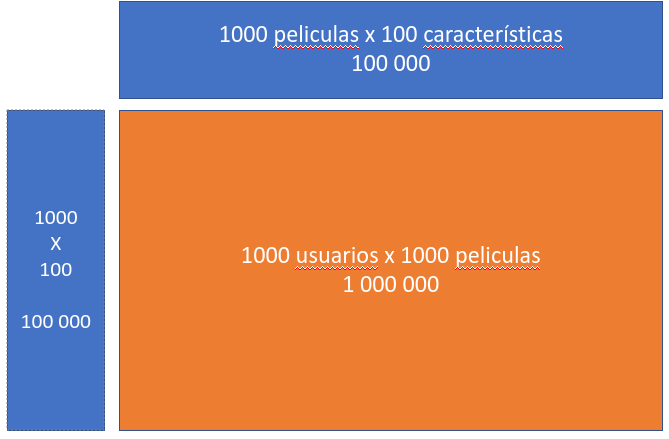

Creamos el modelo con la ayuda de Pytorch.

In [ ]:
class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
      super().__init__()
      self.user_factors = torch.nn.Embedding(n_users, n_factors, sparse=True)
      self.item_factors = torch.nn.Embedding(n_items, n_factors, sparse=True)
      self.user_biases = torch.nn.Embedding(n_users, 1, sparse=True)
      self.item_biases = torch.nn.Embedding(n_items, 1, sparse=True)

    def forward(self, user, item):
      x = self.user_biases(user) + self.item_biases(item)
      x = x + (self.user_factors(user) * self.item_factors(item)).sum(1, keepdim=True)
      return x


Separamos los datos para entreno y test

In [ ]:
train_data, test_data = train_test_split(ratings[["uId", "mId", "rating"]], test_size=0.1)

In [ ]:
train = CustomDataset(train_data.values)

In [ ]:
train[:5]

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = MatrixFactorization(nusers, nmovies, n_factors=40).to(device)
optim = torch.optim.SparseAdam(net.parameters(), lr=1e-2)
criterion = nn.MSELoss()

In [ ]:
train_loader = DataLoader(train, batch_size=2000, shuffle=True)

In [ ]:
h_loss = []
net.train()
for epoch in range(5):
  bar = tqdm(train_loader)
  bar.set_description("Loss: 0.0")
  for x in bar:
    original = x.to(device)
    output = net(original[:,0].int(), original[:,1].int())
    optim.zero_grad()
    original = original[:,2].unsqueeze(-1).float()
    loss = criterion(output, original)
    loss.backward()
    optim.step()
    h_loss.append(loss.item())
    bar.set_description(f"Loss: {np.mean(h_loss[-50:]):.3f}")


In [ ]:
plt.figure(figsize=(20,5))
plt.plot(h_loss)
plt.show()

Validamos con el set de test

In [ ]:
test = CustomDataset(test_data.values)
test_loader = DataLoader(test, batch_size=2000, shuffle=True)

In [ ]:
net.eval()
h_loss = []
bar = tqdm(test_loader)
bar.set_description("Loss: 0.0")
for x in bar:
  original = x.to(device)
  output = net(original[:,0].int(), original[:,1].int())
  original = original[:,2].unsqueeze(-1).float()
  loss = torch.sqrt(criterion(output, original))
  h_loss.append(loss.item())
  bar.set_description(f"Loss: {np.mean(h_loss[-50:]):.3f}")

In [ ]:
np.mean(h_loss)

Podemos visualizar los ranking de las películas de un usuario aleatorio.

In [ ]:
random_user = np.random.choice(test_data['uId'].unique())

random_user_tdata = train_data[train_data['uId'] == random_user].sort_values('rating', ascending=False)
random_user_tdata = random_user_tdata.merge(movies, how='left', on='mId')

random_user_data = test_data[test_data['uId'] == random_user].sort_values('rating', ascending=False)
random_user_data = random_user_data.merge(movies, how='left', on='mId')
print(len(random_user_tdata), len(random_user_data))

In [ ]:
random_user_data['position'] = list(range(len(random_user_data)))

In [ ]:
with torch.no_grad():
  user_data = torch.from_numpy(random_user_data.iloc[:,:2].values).int().to(device)
  output = net(user_data[:,0], user_data[:,1])
  random_user_data['predicted'] = output.cpu().numpy()
random_user_data = random_user_data.merge(movies, how='left').sort_values('predicted', ascending=False)
random_user_data.iloc[:10]

In [ ]:
movies_not_seen = np.array(list(set(a_movies) - set(random_user_tdata['mId'])))

In [ ]:
all_movies = np.stack([np.repeat(random_user, len(movies_not_seen)),movies_not_seen], axis=1)

In [ ]:
with torch.no_grad():
  user_data = torch.from_numpy(all_movies[:, :2]).int().to(device)
  output = net(user_data[:,0], user_data[:,1])
  output_df = pd.DataFrame(all_movies, columns=['uId', 'mId'])
  output_df['ratings'] = output.cpu().numpy()

In [ ]:
output_df = output_df.sort_values('ratings', ascending=False).iloc[:10].merge(movies, how='left', on='mId')
print((output_df['movieId'].isin(random_user_data['movieId'])).any())
output_df

#AutoREC

Sistema de recomendación basado en autoencoders

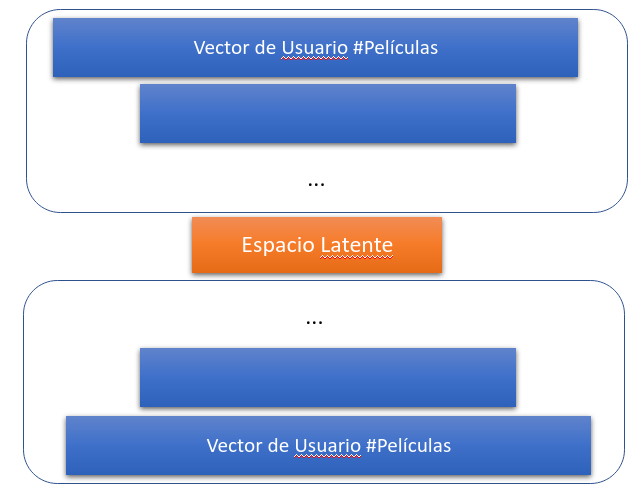

Let $r_{:,i}$ denote the i th column of the rating matrix, where unknown ratings are set to zeros by default. 

Arquitectura:

$$h(r_{:,i}) = f(W · g(V r_{:,i} + \mu) + b)$$



Error de reconstrucción:
$$
\underset{\mathbf{W},\mathbf{V},\mu, b}{\mathrm{argmin}} \sum_{i=1}^M{\parallel \mathbf{r}_{:,i} - h(\mathbf{r}_{:, i})\parallel_{\mathcal{O}}^2} +\lambda(\| \mathbf{W} \|_F^2 + \| \mathbf{V}\|_F^2)
$$

y  $\| \cdot \|_{\mathcal{O}}$ significa que solo vamos a usar los valores observados. Solo los pesos de esos valores serán actualizados cuando usemos backprop.

Lo primero es pasar los datos a vector de usuarios.

In [ ]:
data = ratings.groupby('uId')[['mId', 'rating']].agg(lambda x: list(x))
data.iloc[0]

In [ ]:
#Creación de vector usuarios
def get_vector(row):
  v = np.zeros(nmovies, dtype=np.float16)
  v[row['mId']] = row['rating']
  return v

data = data.apply(get_vector, axis=1)
data[0].shape

In [ ]:
data = np.stack(data.to_numpy())
data.shape

Creamos la red neuronal correspondiente al autoencoder

In [ ]:
class AutoRect(nn.Module):
    def __init__(self, num_items, latent = 500):
        super().__init__()
        self.encoder = nn.Linear(num_items, latent)
        self.drop = nn.Dropout(0.05)
        self.output = nn.Linear(latent, num_items)

    def forward(self, x):
      enc = self.drop(torch.sigmoid(self.encoder(x)))
      out = self.output(enc)
      if self.training:
        out = torch.sign(x) * out
      return out 
      

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = AutoRect(nmovies).to(device)
optim = torch.optim.Adam(net.parameters(), weight_decay=0.001)
criterion = nn.MSELoss()

In [ ]:
train_data, test_data, train_users, test_users = train_test_split(data, ratings['uId'].unique(),  test_size=0.05,)

In [ ]:
train = CustomDataset(train_data)

In [ ]:
train_loader = DataLoader(train, batch_size=100, shuffle=True)

In [ ]:
h_loss = []
net.train()
for epoch in range(3):
  bar = tqdm(train_loader)
  bar.set_description("Loss: 0.0")
  for x in bar:
    original = x.float().to(device)
    output = net(original)
    optim.zero_grad()
    loss = criterion(output, original)
    loss.backward()
    optim.step()
    h_loss.append(loss.item())
    bar.set_description(f"Loss: {np.mean(h_loss[-50:]):.3f}")

In [ ]:
net.eval()
h_loss = []
bar = tqdm(test_data)
bar.set_description("Loss: 0.0")
for x in bar:
  original = torch.from_numpy(x).float().to(device)
  output = net(original)
  loss = torch.sqrt(criterion(output, original))
  h_loss.append(loss.item())
  bar.set_description(f"Loss: {np.mean(h_loss[-50:]):.3f}")


In [ ]:
random_index = np.random.choice(len(test_data))
random_user = test_users[random_index]
r_user_movies = test_data[random_index]
best_10_movies = np.argsort(r_user_movies)[::-1][:10]
best_10_movies, r_user_movies[best_10_movies]

In [ ]:
with torch.no_grad():
  output = torch.from_numpy(r_user_movies).float().to(device)
  output = net(output).cpu().numpy()

t = ratings[(ratings['mId'].isin(best_10_movies)) & (ratings['uId'] == random_user)].merge(movies, how='left')
t['predicted'] = output[t['mId']]
t

In [ ]:
index_to_0 = np.random.choice(best_10_movies)
r_user_movies[index_to_0] = 0
index_to_0

In [ ]:
with torch.no_grad():
  output = torch.from_numpy(r_user_movies).float().to(device)
  output = net(output).cpu().numpy()
  
best_rating_movies = np.argsort(output)[::-1][:10]
best_rating_movies, output[best_rating_movies]

In [ ]:
t = movies[movies['mId'].isin(best_rating_movies)]
t['rating'] =  output[t['mId']]
t

In [ ]:
#Hit Ratio @ 10
net.eval()
with torch.no_grad():
  hits = []
  bar = tqdm(test_data)
  for y in bar:
    x = y.copy()
    best_user_movies = np.argsort(x)[::-1][:10]
    random_index = np.random.choice(best_user_movies)
    x[random_index] = 0
    x = torch.from_numpy(x).float().to(device)
    output = net(x).cpu().numpy()
    best_rating_movies = np.argsort(output)[::-1][:10]
    if random_index in best_rating_movies:
      hits.append(1)
    else:
      hits.append(0)



In [ ]:
print("The Hit Ratio @ 10 is {:.2f}".format(np.mean(hits)))